## Neural Style Transfer

The first approach for Neural Style Transfer is based on directly optimizing the image pixel values. This does not involve training a network, instead we use a pretrained network and the loss is based on the features extracted from this network.

However this approach is very inefficient because we have to run optimization for every new style-content image pair. Johnson et al. proposed a way to perform Style Transfer using a feed-forward network. So, instead of optimizing the image pixels we pass the image through an Image Transformation Netork and we learn the weights of this network. This is the approach that I have implemented for this assignment. The only drawback of this method is that the network is tied to a singly style so for a new art-style we would need to train a new network.

Follow up works generalize this to a larger number of styles per network but because of time and resource consraints I decided to go with the simpler approach.

For training we take a dataset of content images and a single style image. We have three types of loss in our objective

- Content Loss
- Style Loss
- Total Variation Loss

These losses are based on features extracted from a pre-trained VGG network. It is largely based on empirical evidence. The earlier layers of a well trained CNN are good at recognising the fine grained details or in a way the content of the image. Each trainign example has the content image, a style image and an input image which we transform using the Image Transformation Network. Empirically taking the input image as the content image itself gives best results. We pass the transformed image and the content image into the pretrained VGG and the content loss is simply the MSE between the feature responses of certain layers (For VGG16 _relu_1_2_ and _relu_2_2_ seem to work well and are the most used in literature).

For capturing the style, the correlation matrices of the feature responses are made similar. More specifically if we have the activations of some layer in the shape $C \times H \times W$, then we compute the correlation matrix of $C$ features of shape $HW$. In the case of VGG16 we do this for activations from layers _relu_3_3_ and _relu_4_3_

The TV Loss is just a regularizer used to encourage spatial smoothness in the output image.

In [1]:
import numpy as np
import torch
from utils import *

# Outlined in Johnson et al.
from transformer import TransformerNet

# pretrained VGG to extract features form relu_1_2, relu_2_2, relu_3_3 and relu_4_3
from vgg import PerceptualLossNet

from torch.optim import Adam
import time
from PIL import Image
import os
import pickle
from torch.utils.data import random_split

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Model Architecture
The perceptual loss network is simply a VGG16 pretrained on ImageNet. For the Image Transformation Net I have used the network described in Johnson et al. with some changes like using Instance Norm instead of Batch Norm and some other modifications which are known to give better results based on follow up papers and work. 

We have three conv layers followed by Instance Norm layers to downsample the image. This is followed by Residual Blocks and finally Upsampling is done using Nearest Neaighbor upsampling follwoed by conv layers to get to an ouptut the same shape as the input. 

In [2]:
# Hyperparameters
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "./data"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "./style_image.jpeg"
CONTENT_IMAGE_PATH = "content.jpeg"
BATCH_SIZE = 4
CONTENT_WEIGHT = 1e0
STYLE_WEIGHT = 4e5
TV_WEIGHT = 1e-6
LR = 0.001
SAVE_MODEL_PATH = "./checkpoints"
SAVE_IMAGE_PATH = "./image_outputs"
CHECKPOINT_FREQ = 150
LOG_FREQ = 50

# Setting the seed value for reproducibility
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

## Training

This class encapsulates all the training logic. The original MSCOCO dataset used in the literature for these models is very large with ~83k images. Because I did not have access to any GPUs I have used a very small version of this dataset with Training Set Size : 12417 and Validation Set Size : 165. For the style image we use a painting by picasso saved as `style_image.jpeg`

Style Transfer is inherently an ill posed problem becuase the quality of the output can't be mesaured objectively and boild down to personal prefernce and aesthetics. Because of this reason we can only use the loss function as a proxy for measuring performance.

I did not have the resources to perform proper hyper-parameter tuning so most of the hyperparameters have been taken from the paper. For model selection, we keep track of the validation loss and pick the model with the best validation loss.

In [3]:
class StyleTransfer:
    def __init__(
        self,
        num_epochs=NUM_EPOCHS,
        image_size=TRAIN_IMAGE_SIZE,
        dataset_path=DATASET_PATH,
        style_image_path=STYLE_IMAGE_PATH,
        content_image_path=CONTENT_IMAGE_PATH,
        batch_size=BATCH_SIZE,
        style_weight=STYLE_WEIGHT,
        content_weight=CONTENT_WEIGHT,
        tv_weight=TV_WEIGHT,
        log_freq=LOG_FREQ,
        checkpoint_freq=CHECKPOINT_FREQ,
        lr=LR,
        save_model_path=SAVE_MODEL_PATH,
        save_image_path=SAVE_IMAGE_PATH
    ):
        self.epochs = num_epochs
        self.image_size = image_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.style_image_path = style_image_path
        self.content_image_path = content_image_path
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.tv_weight = tv_weight
        self.lr = lr
        self.log_freq = log_freq
        self.checkpoint_freq = checkpoint_freq
        self.save_model_path = save_model_path
        self.save_image_path = save_image_path

        # load data
        print("Loading Data...")
        self.train_loader, self.val_loader = get_training_data_loader(dataset_path, image_size, batch_size)
        print("Data Loaded Successfully \n")
        
        # instantiate networks
        self.transformer_net = TransformerNet().train().to(self.device)
        self.perceptual_loss_net = PerceptualLossNet(requires_grad=False).to(self.device)

        self.optimizer = Adam(self.transformer_net.parameters())

        # Compute Gram matrices for the style image
        style_img = prepare_img(style_image_path, self.device, batch_size=batch_size)
        style_img_set_of_feature_maps = self.perceptual_loss_net(style_img)
        self.target_style_representation = [gram_matrix(x) for x in style_img_set_of_feature_maps]
        
        # This image is used to keep track of the subjective performance over the iteration
        # sotred in the directory "save_image_path" after every log_iter iterations
        self.test_image = prepare_img(content_image_path, self.device)
        
        self.mse_loss = torch.nn.MSELoss(reduction='mean')

        self.best_val_loss = None
        
        self.history = {
            'content_loss_t': [],
            'style_loss_t': [],
            'tv_loss_t': [],
            'total_loss_t': [],
            'total_loss_v' : []
        }
    
    
    def train(self):
        print("Training Started...\n")
        
        ts = time.time()
        
        acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]
        
        for epoch in range(self.epochs):
            for batch_id, (content_batch, _) in enumerate(self.train_loader):
                # get ouput of transform_net
                content_batch = content_batch.to(self.device)
                stylized_batch = self.transformer_net(content_batch)

                # feed batch of style and content images to the vgg net
                content_batch_set_of_feature_maps = self.perceptual_loss_net(content_batch)
                stylized_batch_set_of_feature_maps = self.perceptual_loss_net(stylized_batch)

                # compute content loss
                target_content_representation = content_batch_set_of_feature_maps.relu2_2
                current_content_representation = stylized_batch_set_of_feature_maps.relu2_2
                content_loss = self.content_weight * self.mse_loss(target_content_representation, current_content_representation)
                acc_content_loss += content_loss.item()
                
                # compute gram matrices and style loss
                style_loss = 0.0
                current_style_representation = [gram_matrix(x) for x in stylized_batch_set_of_feature_maps]
                for gram_gt, gram_hat in zip(self.target_style_representation, current_style_representation):
                    style_loss += self.mse_loss(gram_gt, gram_hat)
                style_loss /= len(self.target_style_representation)
                style_loss *= self.style_weight
                acc_style_loss += style_loss.item()

                # compute tv loss
                tv_loss = self.tv_weight * total_variation(stylized_batch)
                acc_tv_loss += tv_loss.item()

                # backprop
                total_loss = content_loss + style_loss + tv_loss
                total_loss.backward()
                self.optimizer.step()

                self.optimizer.zero_grad()
                
                if (batch_id + 1) % self.log_freq == 0:
                    with torch.no_grad():
                        self.history['content_loss_t'].append(acc_content_loss / self.log_freq)
                        self.history['style_loss_t'].append(acc_style_loss / self.log_freq)
                        self.history['tv_loss_t'].append(acc_tv_loss / self.log_freq)
                        self.history['total_loss_t'].append((acc_content_loss + acc_style_loss + acc_tv_loss) / self.log_freq)

                        self.transformer_net.eval()
                        stylized_test = self.transformer_net(self.test_image).cpu().numpy()[0]
                        val_loss = self.val_loss()
                        self.transformer_net.train()
                        stylized = post_process_image(stylized_test)
                        stylized_image = Image.fromarray(stylized)

                        stylized_image.save(os.path.join(self.save_image_path, f"iter-{batch_id + 1}.jpeg"))
                        
                        
                        
                        if self.best_val_loss is None or val_loss < self.best_val_loss:
                            self.best_val_loss = val_loss
                            torch.save(self.transformer_net.state_dict(), "best_model.pth")
                            
                        print(f'Iter : [{batch_id + 1}/{len(self.train_loader)}]')
                        print('---------------------\n')
                        print(f'Time Elapsed : {(time.time() - ts) / 60:.2f} min)')
                        print('Training Loss :')
                        print(f'\tContent Loss : {acc_content_loss / self.log_freq}')
                        print(f'\tStyle Loss : {acc_style_loss / self.log_freq}')
                        print(f'\tTV Loss : {acc_tv_loss / self.log_freq}')
                        print(f'\tTotal Loss : {(acc_content_loss + acc_style_loss + acc_tv_loss) / self.log_freq}')
                        print(f'Validation Loss : {val_loss}\n\n')
                    
                        
                        acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]

                
                if (batch_id + 1) % self.checkpoint_freq == 0:
                    torch.save(self.transformer_net.state_dict(),
                               os.path.join(self.save_model_path, f"iter-{batch_id + 1}.pth"))


                            
    def val_loss(self):
        val_loss = 0.0
        for batch_id, (content_batch, _) in enumerate(self.val_loader):
            content_batch = content_batch.to(self.device)
            stylized_batch = self.transformer_net(content_batch)
            
            content_batch_set_of_feature_maps = self.perceptual_loss_net(content_batch)
            stylized_batch_set_of_feature_maps = self.perceptual_loss_net(stylized_batch)
            
            target_content_representation = content_batch_set_of_feature_maps.relu2_2
            current_content_representation = stylized_batch_set_of_feature_maps.relu2_2
            content_loss = self.content_weight * self.mse_loss(target_content_representation, current_content_representation)

            style_loss = 0.0
            current_style_representation = [gram_matrix(x) for x in stylized_batch_set_of_feature_maps]
            for gram_gt, gram_hat in zip(self.target_style_representation, current_style_representation):
                style_loss += self.mse_loss(gram_gt, gram_hat)
            style_loss /= len(self.target_style_representation)
            style_loss *= self.style_weight
            
            tv_loss = self.tv_weight * total_variation(stylized_batch)

            val_loss += (content_loss + style_loss + tv_loss).item()
            
        val_loss /= len(self.val_loader)
        self.history['total_loss_v'].append(val_loss)
                
        return val_loss

In [4]:
style_transfer = StyleTransfer()

Loading Data...
Training Set Size : 12417
Validation Set Size : 165
Data Loaded Successfully 



In [5]:
style_transfer.train()

Training Started...

Iter : [50/3104]
---------------------

Time Elapsed : 3.98 min)
Training Loss :
	Content Loss : 5.896325945854187
	Style Loss : 22.590444736480713
	TV Loss : 0.010260178977623581
	Total Loss : 28.497030861312524
Validation Loss : 16.112683831191646


Iter : [100/3104]
---------------------

Time Elapsed : 7.83 min)
Training Loss :
	Content Loss : 6.218272294998169
	Style Loss : 7.8433964061737065
	TV Loss : 0.01610710009932518
	Total Loss : 14.0777758012712
Validation Loss : 12.959503011005681


Iter : [150/3104]
---------------------

Time Elapsed : 11.62 min)
Training Loss :
	Content Loss : 6.414031019210816
	Style Loss : 5.110530691146851
	TV Loss : 0.027502804920077326
	Total Loss : 11.552064515277744
Validation Loss : 10.676465197307307


Iter : [200/3104]
---------------------

Time Elapsed : 15.48 min)
Training Loss :
	Content Loss : 6.271551103591919
	Style Loss : 3.241663193702698
	TV Loss : 0.038484288081526756
	Total Loss : 9.551698585376144
Validation 

Iter : [1700/3104]
---------------------

Time Elapsed : 131.74 min)
Training Loss :
	Content Loss : 3.45190468788147
	Style Loss : 1.1982673704624176
	TV Loss : 0.055411375984549524
	Total Loss : 4.705583434328437
Validation Loss : 4.943409925553857


Iter : [1750/3104]
---------------------

Time Elapsed : 135.58 min)
Training Loss :
	Content Loss : 3.4402794075012206
	Style Loss : 1.1727642726898193
	TV Loss : 0.05563922464847565
	Total Loss : 4.668682904839516
Validation Loss : 4.874082326889038


Iter : [1800/3104]
---------------------

Time Elapsed : 139.43 min)
Training Loss :
	Content Loss : 3.432109341621399
	Style Loss : 1.1806123507022859
	TV Loss : 0.055538036599755286
	Total Loss : 4.66825972892344
Validation Loss : 4.861075116366875


Iter : [1850/3104]
---------------------

Time Elapsed : 143.27 min)
Training Loss :
	Content Loss : 3.4983985567092897
	Style Loss : 1.2048286271095277
	TV Loss : 0.05545644231140614
	Total Loss : 4.758683626130224
Validation Loss : 4.8524

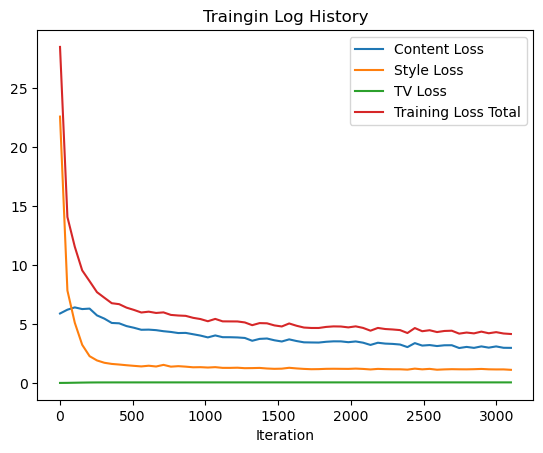

In [6]:
from matplotlib import pyplot as plt

log_dict = style_transfer.history

x = np.linspace(1, len(log_dict['content_loss_t'])*style_transfer.log_freq, len(log_dict['content_loss_t']))
plt.plot(x, log_dict['content_loss_t'], label='Content Loss')
plt.plot(x, log_dict['style_loss_t'], label='Style Loss')
plt.plot(x, log_dict['tv_loss_t'], label='TV Loss')
plt.plot(x, log_dict['total_loss_t'], label='Training Loss Total')

plt.xlabel('Iteration')
plt.title('Traingin Log History')
plt.legend()

## Improvements and Further Scope

- Because of the serious time and resource constraints the methods in literature that were feasible to explore was greatly reduced. So a more thorough literature study would have resulted in better results.

- Proper hyperparameter tuning would help squeeze out even more performance from this approach itself. Also implementing a LR scheduler might have lead to a lower loss.

- Overall there was a lot more expermentation that could've been done given more time and appropriate computing power. 